# Biblioteki

In [1]:
import os
import mne
import numpy as np
from scipy.signal import butter, filtfilt
from scipy import signal, misc
import matplotlib.pyplot as plt

# Ładowanie danych z pliku

In [2]:
PATH_KONTROLA = "C:/Users/kuba_/Desktop/Studia/semestr7/eeg/project/pacjenci/"

if(os.path.exists(PATH_KONTROLA)):
    file_names = os.listdir(PATH_KONTROLA)
    kontrola_bdf_paths = [PATH_KONTROLA + str(file_name) for file_name in file_names]
    
print("Katalog kontroli zawiera ", len(kontrola_bdf_paths), " plików")

Katalog kontroli zawiera  32  plików


In [3]:
raw_files = []

for path in kontrola_bdf_paths:
    raw = mne.io.read_raw_bdf(path)
    raw_files.append(raw)

Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\pacjenci\pcf01_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\pacjenci\pcf01_03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\pacjenci\pcf02_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\pacjenci\pcf02_03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\pacjenci\pcf04_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desk

###### Wczytanie eventow i czestotliwosci probkowania.
Zamiana osi czasu na sekundy

In [13]:
events = []
sampling_freq_all = []

for count, raw in enumerate(raw_files):
    sampling_freq_all.append(raw.info['sfreq'])
    events.append(mne.find_events(raw, stim_channel='Status', initial_event=True))
    events[count][:, 0] = events[count][:, 0] * sampling_freq_all[count] 

296 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584  61692 126976 127230 130303]
225 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584 126976 127230]
374 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584  61692 126976 127230 130303]
224 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584 126976 127230 130303]
371 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584 126976 127230]
295 events found
Event IDs: [ 61440  61508  61512  61520  61572  61576  61584 126976 127230]
224 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584 126976 127230 127231]
298 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584  61692 126976 127230 127231]
3 events found
Event IDs: [ 61692  61695 130303]
301 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584  61694 126976 127230]
222 events found
Event IDs: [ 61508  61512  61520  61572  61576  61584  61695 126976 127230]
297 events fou

In [14]:
print(type(events[0]))
print(len(events[0]))
print(events[0][:5])
print(events[0][1][0])
print(events[0][2][2] - events[0][2][1])
print(np.any(events[:][:][1]) == 0)

<class 'numpy.ndarray'>
296
[[       0        0   130303]
 [ 5025792    61440    61692]
 [13224960    61440    61584]
 [15839232    61440    61520]
 [23207936    61440    61576]]
5025792
144
False


#### Przeskalowanie kolumn w celu uzyskania triggerow: 3 kolumna - 2 kolumna

In [15]:
events_all = np.copy(events)

for count, raw in enumerate(raw_files):
    for event in range(len(events_all[count])):
        events_all[count][event][2] = events_all[count][event][2] - events_all[count][event][1]
        events_all[count][event][1] = 0

print(events_all[0][:5])

[[       0        0   130303]
 [ 5025792        0      252]
 [13224960        0      144]
 [15839232        0       80]
 [23207936        0      136]]


# Cięcie sygnału zgodnie z triggerami

In [16]:
# triggers = [start, stop]
left_triggers = [144, 80]
right_triggers = [136, 72]
rest_triggers = [132, 68]

# slownik dla 3 warunków zawierająca wszystkie triggery uporzadkowane w stosownej kolejnosci w listach
samples_all = {'left': [],
               'rest': []}

for count, raw in enumerate(raw_files):
    left_samples = np.zeros((1,2))
    right_samples = np.zeros((1,2))
    rest_samples = np.zeros((1,2))
    
    # sprawdzenie czy  wartosc 3 kolumny (kod triggera) jest rowny iterowanemu triggerowi
    # sprawdzenie czy wartosc z 1 kolumny eventow nie zostala juz przypisana do tablicy samples
    for e in range(len(events_all[count])):
        if events_all[count][e][2] == left_triggers[1]:
            if events_all[count][e][0] not in left_samples:
                # uzycie jedynie trigger stopu i stworzenie odcinka czasu od sekundy wczesniej do 4 sek po nim
                # oszczednosc obliczen
                left_samples[-1][0] = events_all[count][e][0] - 1000000
                left_samples[-1][1] = events_all[count][e][0] + 4000000
                left_samples = np.vstack([left_samples, [0,0]])

#         if events_all[count][e][2] == right_triggers[1]:
#             if events_all[count][e][0] not in right_samples:
#                 right_samples[-1][0] = events_all[count][e][0] - 1000000
#                 right_samples[-1][1] = events_all[count][e][0] + 4000000
#                 right_samples = np.vstack([right_samples, [0,0]])
                
        if events_all[count][e][2] == rest_triggers[1]:
            if events_all[count][e][0] not in rest_samples:
                rest_samples[-1][0] = events_all[count][e][0] - 1000000
                rest_samples[-1][1] = events_all[count][e][0] + 4000000
                rest_samples = np.vstack([rest_samples, [0,0]])
                

#         if events_all[count][e][0] not in rest_samples:
#             if events_all[count][e][2] == rest_triggers[0]:
#                 rest_samples[-1][0] = events_all[count][e][0] + 1000000
#             if events_all[count][e][2] == rest_triggers[1]:
#                 rest_samples[-1][1] = events_all[count][e][0] + 4000000
#                 rest_samples = np.vstack([rest_samples, [0,0]])                       

    left_samples = np.delete(left_samples, (-1), axis=0) 
#     right_samples = np.delete(right_samples, (-1), axis=0)
    rest_samples = np.delete(rest_samples, (-1), axis=0) 

    left_samples = (left_samples / sampling_freq_all[count]).astype(int)
#     right_samples = (right_samples / sampling_freq_all[count]).astype(int)
    rest_samples = (rest_samples / sampling_freq_all[count]).astype(int) 

    # wpisanie 3 warunkow do slownika    
    samples_all['left'].append(left_samples)
#     samples_all['right'].append(right_samples)
    samples_all['rest'].append(rest_samples)

    
samples_all['left'] = np.array(samples_all['left'])
samples_all['rest'] = np.array(samples_all['rest'])

print(len(left_samples))
print(len(rest_samples))
print(left_samples[:5])
print(rest_samples[:5])

36
36
[[176847 181730]
 [225047 229930]
 [254548 259431]
 [261235 266118]
 [297157 302040]]
[[196325 201208]
 [203000 207883]
 [218374 223257]
 [244800 249683]
 [270976 275859]]


In [26]:
# print(len(samples_all['rest']))
# print(len(samples_all['rest'][0]))
# print(len(samples_all['rest'][-1]))
# print(len(samples_all['left'][0]))

for i in range(len(samples_all['rest'])):
    if len(samples_all['rest'][i]) != 48:
        print(len(samples_all['rest'][i]))
        print(len(samples_all['left'][i]))

# print(len(samples_all['rest'][0][0]))
# print(len(raw_files))

36
36
60
60
36
36
60
60
36
36
0
0
36
36
36
36
36
36
36
36
60
60
36
36
36
36
36
36
36
36
36
36
49
49
36
36
36
36
24
24
36
36


In [19]:
print(len(samples_all['left']), "- Ilosc osob w grupie wykonujacych polecenie uniesienia lewej reki")
print(len(samples_all['left'][0]), "- Ilosc powtorzen komendy w calej probie dla pierwszego pacjenta")

32 - Ilosc osob w grupie wykonujacych polecenie uniesienia lewej reki
48 - Ilosc powtorzen komendy w calej probie dla pierwszego pacjenta


### Wygenerowanie wektora czasu i amplitudy z danych z prawej reki i odpoczynku

In [20]:
left_dataset = np.zeros((len(samples_all['left']), len(samples_all['left'][0])), dtype=object)
left_timeset = np.zeros((len(samples_all['left']), len(samples_all['left'][0])), dtype=object)
rest_dataset = np.zeros((len(samples_all['rest']), len(samples_all['rest'][0])), dtype=object)
rest_timeset = np.zeros((len(samples_all['rest']), len(samples_all['rest'][0])), dtype=object)

for count, raw in enumerate(raw_files):  
    print(count,'idzie')
    for y in range(len(samples_all['left'][count])):
        datay, timey = raw.get_data(start = int(samples_all['left'][count][y][0]), stop = int(samples_all['left'][count][y][1]), return_times=True)
        left_dataset[count][y] = datay
        left_timeset[count][y] = timey
        
    for z in range(len(samples_all['rest'][count])):
        dataz, timez = raw.get_data(start = int(samples_all['rest'][count][z][0]), stop = int(samples_all['rest'][count][z][1]), return_times=True)
        rest_dataset[count][z] = dataz
        rest_timeset[count][z] = timez

    
print(len(left_dataset))
print(len(rest_dataset))
print(len(left_dataset[0]))


0 idzie
1 idzie
2 idzie


IndexError: index 48 is out of bounds for axis 0 with size 48

In [10]:
print(len(left_dataset[0]))
print(len(left_dataset[0][0]))
print(len(left_dataset[0][0][0]))

48
73
4883


# FILTRACJE

In [11]:
def mastoid_filter(data, mastoid_data):
    final_y = np.copy(data)
    y = np.copy(data)
    avg = (mastoid_data[0] + mastoid_data[1]) / 2
    
    for channel in range(len(data)):
        final_y[channel] = y[channel] - avg
        
    return final_y

In [12]:
def small_laplacian_filter(working_data, final_data, times, working_channels):
    averages = np.zeros((len(main_electrodes), len(times)))
    y = np.copy(working_data)
    new_y = np.copy(final_data)
    for channel in range(len(working_channels)):
        if working_channels[channel] in C3_small_laplacian:
            averages[0] = averages[0] + y[channel]
        
        if working_channels[channel] in C4_small_laplacian:
            averages[1] = averages[1] + y[channel]
            
        if working_channels[channel] in Cz_small_laplacian:
            averages[2] = averages[2] + y[channel]
            
    averages = averages/4
    final_y = np.zeros((len(main_electrodes), len(times)))

    for avg in range(len(main_electrodes)):
        if main_channels_order[avg] == main_electrodes[0]:
            final_y[avg] = new_y[avg] - averages[0]
            
        if main_channels_order[avg] == main_electrodes[1]:
            final_y[avg] = new_y[avg] - averages[1]

        if main_channels_order[avg] == main_electrodes[2]:
            final_y[avg] = new_y[avg] - averages[2]
      
    return final_y

In [13]:
def butter_filter(data, low_cutoff, high_cutoff, fs, order, filter_type):
    nyq = 0.5 * fs
    low_normal_cutoff = low_cutoff / nyq
    high_normal_cutoff = high_cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, [low_normal_cutoff, high_normal_cutoff], btype=filter_type, analog=False)
    y = np.copy(data)
    for channel in range(len(y)):
        y[channel] = filtfilt(b, a, np.ravel(y[channel])) 
        
    return y

In [14]:
reference_electrodes = ['EXG1', 'EXG2']
main_electrodes = ['C3', 'C4', 'Cz']

C3_small_laplacian = ['C3', 'FC3', 'C1', 'CP3', 'C5']
C4_small_laplacian = ['C4', 'FC4', 'C6', 'CP4', 'C2']
Cz_small_laplacian = ['Cz', 'FCz', 'C2', 'CPz', 'C1']
other_electrodes = C3_small_laplacian[1:] + C4_small_laplacian[1:] + Cz_small_laplacian[1:]

In [15]:
ch_names_all = []

for count, raw in enumerate(raw_files):
    ch_names = raw.ch_names
    ch_names_all.append(ch_names)

# Stworzenie serii danych tylko dla elektrod potrzebnych do filtracji przestrzennej

In [16]:
# MASTOIDY REST
new_dataset_rest = np.copy(rest_dataset)
mastoidy_dataset_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)

for count in range(len(rest_dataset)):
    print(count, 'cos leci')
    for period in range(len(rest_dataset[count])):
        mastoidy_data = np.zeros((len(ch_names_all[count]), len(rest_timeset[count][period])))

        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in reference_electrodes:
                mastoidy_data[i] = new_dataset_rest[count][period][i]
                
        mastoidy_data = mastoidy_data[np.all(mastoidy_data != 0, axis=1)]
        
        mastoidy_dataset_rest[count][period] = mastoidy_data

        
print(len(mastoidy_dataset_rest[0][0]))

0 cos leci
1 cos leci
2 cos leci
3 cos leci
4 cos leci
5 cos leci
6 cos leci
7 cos leci
8 cos leci
9 cos leci
10 cos leci
11 cos leci
12 cos leci
13 cos leci
14 cos leci
15 cos leci
16 cos leci
17 cos leci
2


In [17]:
# MASTOIDY LEFT
new_dataset_left = np.copy(left_dataset)
mastoidy_dataset_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)

for count in range(len(left_dataset)):
#     if count == 11:
#         continue
    print(count, 'cos leci')
    for period in range(len(left_dataset[count])):
        if type(left_timeset[count][period]) == int:
            print(left_timeset[count][period]) 
        mastoidy_data = np.zeros((len(ch_names_all[count]), len(left_timeset[count][period])))

        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in reference_electrodes:
                mastoidy_data[i] = new_dataset_left[count][period][i]
                
        mastoidy_data = mastoidy_data[np.all(mastoidy_data != 0, axis=1)]
        
        mastoidy_dataset_left[count][period] = mastoidy_data

        
print(len(mastoidy_dataset_left[0][0]))

0 cos leci
1 cos leci
2 cos leci
3 cos leci
4 cos leci
5 cos leci
6 cos leci
7 cos leci
8 cos leci
9 cos leci
10 cos leci
11 cos leci
12 cos leci
13 cos leci
14 cos leci
15 cos leci
16 cos leci
17 cos leci
2


In [18]:
new_dataset_rest = np.copy(rest_dataset)
working_dataset_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)
working_channels_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)
final_dataset_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)

for count in range(len(rest_dataset)):
    print(count, 'cos leci')
    for period in range(len(rest_dataset[count])):
        working_data = np.zeros((len(ch_names_all[count]), len(rest_timeset[count][period])))
        final_data = np.zeros((len(ch_names_all[count]), len(rest_timeset[count][period])))
        working_channels = []
        main_channels_order = []
        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in other_electrodes:
                working_data[i] = new_dataset_rest[count][period][i]
                working_channels.append(ch_names_all[count][i])

            if ch_names_all[count][i] in main_electrodes:
                final_data[i] = new_dataset_rest[count][period][i]
                main_channels_order.append(ch_names_all[count][i])
                
        working_data = working_data[np.all(working_data != 0, axis=1)]
        final_data = final_data[np.all(final_data != 0, axis=1)]
        
        working_dataset_rest[count][period] = working_data
        working_channels_rest[count][period] = working_channels
        final_dataset_rest[count][period] = final_data
        
print("Liczba elektrod = ", len(working_dataset_rest[0][0]))
print(main_channels_order)

0 cos leci
1 cos leci
2 cos leci
3 cos leci
4 cos leci
5 cos leci
6 cos leci
7 cos leci
8 cos leci
9 cos leci
10 cos leci
11 cos leci
12 cos leci
13 cos leci
14 cos leci
15 cos leci
16 cos leci
17 cos leci
Liczba elektrod =  10
['C3', 'Cz', 'C4']


In [19]:
new_dataset_left = np.copy(left_dataset)
working_dataset_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)
working_channels_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)
final_dataset_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)

for count in range(len(left_dataset)):
    print(count, 'cos leci')
    for period in range(len(left_dataset[count])):
        working_data = np.zeros((len(ch_names_all[count]), len(left_timeset[count][period])))
        final_data = np.zeros((len(ch_names_all[count]), len(left_timeset[count][period])))
        working_channels = []
        main_channels_order = []
        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in other_electrodes:
                working_data[i] = new_dataset_left[count][period][i]
                working_channels.append(ch_names_all[count][i])

            if ch_names_all[count][i] in main_electrodes:
                final_data[i] = new_dataset_left[count][period][i]
                main_channels_order.append(ch_names_all[count][i])
                
        working_data = working_data[np.all(working_data != 0, axis=1)]
        final_data = final_data[np.all(final_data != 0, axis=1)]
        
        working_dataset_left[count][period] = working_data
        working_channels_left[count][period] = working_channels
        final_dataset_left[count][period] = final_data
        
print("Liczba elektrod = ", len(working_dataset_left[0][0]))
print(main_channels_order)

0 cos leci
1 cos leci
2 cos leci
3 cos leci
4 cos leci
5 cos leci
6 cos leci
7 cos leci
8 cos leci
9 cos leci
10 cos leci
11 cos leci
12 cos leci
13 cos leci
14 cos leci
15 cos leci
16 cos leci
17 cos leci
Liczba elektrod =  10
['C3', 'Cz', 'C4']


### Odpoczynek

In [20]:
print(len(working_dataset_rest))
print(len(working_dataset_rest[11]))
print(len(working_dataset_rest[0][0])) 
print(len(working_dataset_rest[0][0][0]))

18
48
10
4883


### Lewa reka

In [21]:
print(len(left_dataset))
print(len(left_dataset[11]))
print(len(left_dataset[0][0])) 
print(len(left_dataset[0][0][0]))

18
48
73
4883


### Filtracja z uzyciem mastoid dla odpoczynku

In [22]:
filtered_signal_rest = np.copy(working_dataset_rest)
filtered_signal_left = np.copy(working_dataset_left)
'''
count - liczba pacjentow
period - liczba odcinkow czasu
'''

for count in range(len(working_dataset_rest)):
    print(count, "cos sie dzieje")
    
    for period in range(len(working_dataset_rest[count])):
            REST_mastoid_filter = mastoid_filter(working_dataset_rest[count][period], mastoidy_dataset_rest[count][period])
            filtered_signal_rest[count][period] = REST_mastoid_filter
            LEFT_mastoid_filter = mastoid_filter(working_dataset_left[count][period], mastoidy_dataset_left[count][period])
            filtered_signal_left[count][period] = LEFT_mastoid_filter
            
print("udalo sie")

0 cos sie dzieje
1 cos sie dzieje
2 cos sie dzieje
3 cos sie dzieje
4 cos sie dzieje
5 cos sie dzieje
6 cos sie dzieje
7 cos sie dzieje
8 cos sie dzieje
9 cos sie dzieje
10 cos sie dzieje
11 cos sie dzieje
12 cos sie dzieje
13 cos sie dzieje
14 cos sie dzieje
15 cos sie dzieje
16 cos sie dzieje
17 cos sie dzieje
udalo sie


### Filtracja przestrzenna odpoczynek

In [23]:
new_filtered_signal_rest = np.copy(filtered_signal_rest)
new_filtered_signal_left = np.copy(filtered_signal_left)

for count in range(len(rest_dataset)):
    print(count, "cos sie dzieje")    
    for period in range(len(rest_dataset[count])):
        new_filtered_signal_rest[count][period] = small_laplacian_filter(filtered_signal_rest[count][period], final_dataset_rest[count][period], rest_timeset[count][period], working_channels_rest[count][period])
        new_filtered_signal_left[count][period] = small_laplacian_filter(filtered_signal_left[count][period], final_dataset_left[count][period], left_timeset[count][period], working_channels_left[count][period])

0 cos sie dzieje
1 cos sie dzieje
2 cos sie dzieje
3 cos sie dzieje
4 cos sie dzieje
5 cos sie dzieje
6 cos sie dzieje
7 cos sie dzieje
8 cos sie dzieje
9 cos sie dzieje
10 cos sie dzieje
11 cos sie dzieje
12 cos sie dzieje
13 cos sie dzieje
14 cos sie dzieje
15 cos sie dzieje
16 cos sie dzieje
17 cos sie dzieje


### Filtracja czestotliwosciowa

In [24]:
order = 5
low_cutoff = 2
high_cutoff = 42
final_filtered_signal_rest = np.copy(new_filtered_signal_rest)
final_filtered_signal_left = np.copy(new_filtered_signal_left)

for count, raw in enumerate(raw_files):
    sampling_freq = raw.info['sfreq']
    print(count, "dzieje sie")
    for period in range(len(new_filtered_signal_rest[count])):
        final_filtered_signal_rest[count][period] = butter_filter(new_filtered_signal_rest[count][period], low_cutoff, high_cutoff, sampling_freq, order, 'band')
        final_filtered_signal_left[count][period] = butter_filter(new_filtered_signal_left[count][period], low_cutoff, high_cutoff, sampling_freq, order, 'band')
        
        



0 dzieje sie


C:\Users\kuba_\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


1 dzieje sie
2 dzieje sie
3 dzieje sie
4 dzieje sie
5 dzieje sie
6 dzieje sie
7 dzieje sie
8 dzieje sie
9 dzieje sie
10 dzieje sie
11 dzieje sie
12 dzieje sie
13 dzieje sie
14 dzieje sie
15 dzieje sie
16 dzieje sie
17 dzieje sie


In [25]:
print((final_filtered_signal_left[0][0][0][0]))
print(len(final_filtered_signal_left[0][0]))

-6.839845630510428e-06
3


In [34]:
left_vectors = np.zeros((len(final_filtered_signal_left), len(final_filtered_signal_left[0])), dtype=object)
rest_vectors = np.zeros((len(final_filtered_signal_rest), len(final_filtered_signal_rest[0])), dtype=object)

for patient in range(len(final_filtered_signal_left)):
    sampling_freq = sampling_freq_all[patient]
    print(patient, 'leci')
    for period in range(len(final_filtered_signal_left[patient])):
        L_vector = []
        R_vector = []
        for electrode in range(len(final_filtered_signal_left[patient][period])):
# LEFT ARM
            data_feat_left = final_filtered_signal_left[patient][period][electrode]
            # HJORTH
            dt = 1 / sampling_freq
            
            m0 = np.mean(np.square(data_feat_left))
            m2 = np.mean(np.square(np.diff(data_feat_left) / dt))
            zx = np.diff(data_feat_left) / dt
            m4 = np.mean(np.square(np.diff(zx) / dt))
            
            activity = np.sqrt(m0)
            mobility = np.sqrt(m2/m0)
            complexity = np.sqrt((m4 / m2) - (m2/m0))
            
            # STATS
            average = np.average(data_feat_left)
            coeff_of_variation = (np.std(data_feat_left)) / average
            zero_crossings = len(list(np.where(np.diff(np.sign(data_feat_left)))[0]))
            
            L_vector.extend([activity, mobility, complexity, average, coeff_of_variation, zero_crossings])     
# REST 
            data_feat_rest = final_filtered_signal_rest[patient][period][electrode]
            # HJORTH
            dt = 1 / sampling_freq
            
            m0 = np.mean(np.square(data_feat_rest))
            m2 = np.mean(np.square(np.diff(data_feat_rest) / dt))
            zx = np.diff(data_feat_rest) / dt
            m4 = np.mean(np.square(np.diff(zx) / dt))
            
            activity = np.sqrt(m0)
            mobility = np.sqrt(m2/m0)
            complexity = np.sqrt((m4 / m2) - (m2/m0))
            
            # STATS
            average = np.average(data_feat_rest)
            coeff_of_variation = (np.std(data_feat_rest)) / average
            std = np.std(data_feat_rest)
            zero_crossings = len(list(np.where(np.diff(np.sign(data_feat_rest)))[0]))
            
            R_vector.extend([activity, mobility, complexity, average, coeff_of_variation, zero_crossings])
     
        left_vectors[patient][period] = L_vector
        rest_vectors[patient][period] = R_vector

print("Kolejnosc elektrod w wektorze: ", main_channels_order)
print("Dlugosc pojedynczego wektora: ", len(left_vectors[0][0]))
print("")
print("Przykladowe wartosci cech dla 1 pacjenta, eksperymentu UNIESIENIA LEWEJ REKI, 1 fragmentu i elektrody C3:")
print("Aktywnosc = ", left_vectors[0][0][0])
print("Ruchliwosc = ", left_vectors[0][0][1])
print("Zlozonosc = ", left_vectors[0][0][2])
print("Srednia = ", left_vectors[0][0][3])
print("Wspolczynnik zmiennosci = ", np.abs(left_vectors[0][0][4]))
print("Liczba zerowych elementów = ", left_vectors[0][0][5])
print("")
print("")
print("Przykladowe wartosci cech dla 1 pacjenta, eksperymentu ODPOCZYNKU, 1 fragmentu i elektrody C3:")
print("Aktywnosc = ", rest_vectors[0][0][0])
print("Ruchliwosc = ", rest_vectors[0][0][1])
print("Zlozonosc = ", rest_vectors[0][0][2])
print("Srednia = ", rest_vectors[0][0][3])
print("Wspolczynnik zmiennosci = ", np.abs(rest_vectors[0][0][4]))
print("Liczba zerowych elementów = ", rest_vectors[0][0][5])

0 leci
1 leci
2 leci
3 leci
4 leci
5 leci
6 leci
7 leci
8 leci
9 leci
10 leci
11 leci
12 leci
13 leci
14 leci
15 leci
16 leci
17 leci
Kolejnosc elektrod w wektorze:  ['C3', 'Cz', 'C4']
Dlugosc pojedynczego wektora:  18

Przykladowe wartosci cech dla 1 pacjenta, eksperymentu UNIESIENIA LEWEJ REKI, 1 fragmentu i elektrody C3:
Aktywnosc =  1.2338748228965193e-05
Ruchliwosc =  71.4267177651379
Zlozonosc =  172.41902457202963
Srednia =  -1.1017833234932177e-07
Wspolczynnik zmiennosci =  111.98441689653255
Liczba zerowych elementów =  146


Przykladowe wartosci cech dla 1 pacjenta, eksperymentu ODPOCZYNKU, 1 fragmentu i elektrody C3:
Aktywnosc =  1.0965100261143001e-05
Ruchliwosc =  72.50950480206858
Zlozonosc =  160.77761888083916
Srednia =  -3.530646798510638e-08
Wspolczynnik zmiennosci =  310.5675544794497
Liczba zerowych elementów =  136


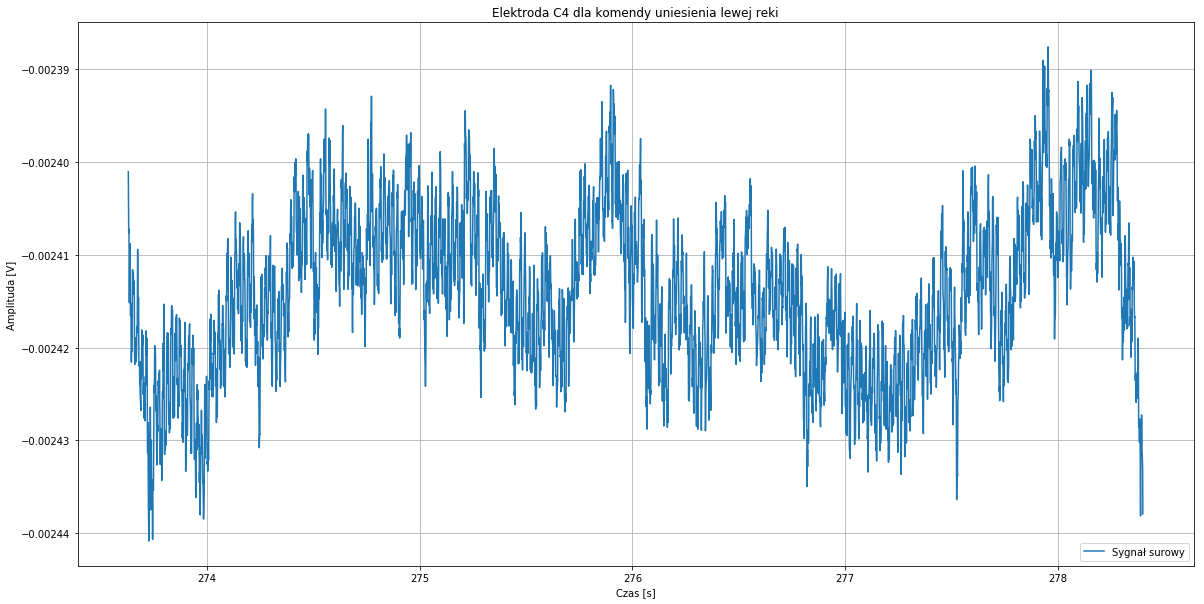

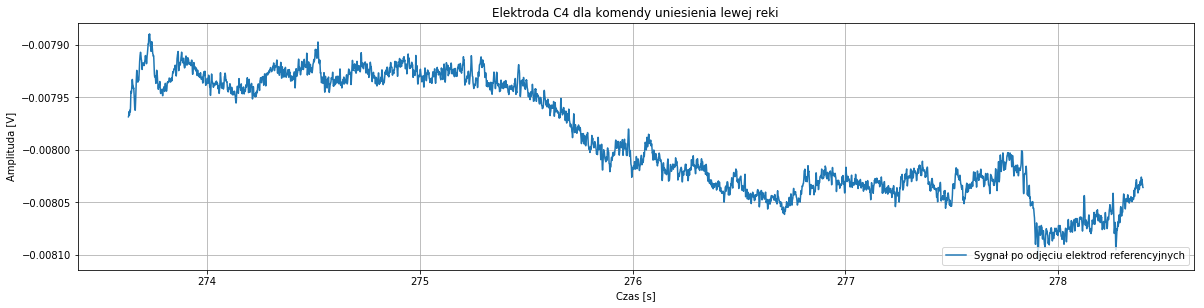

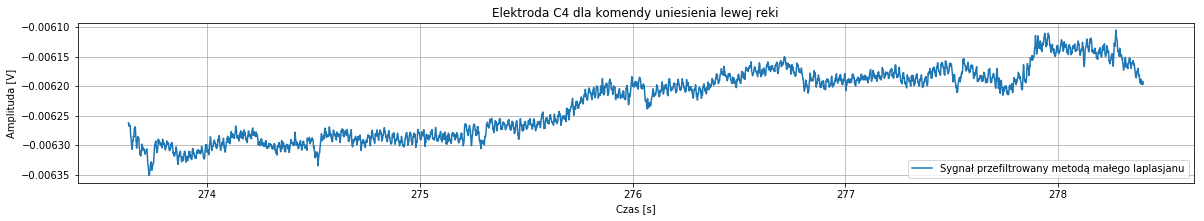

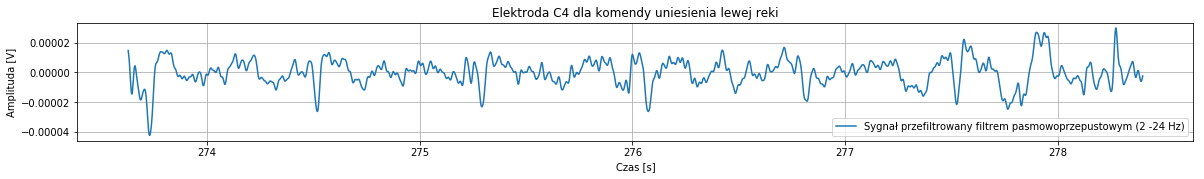

In [36]:
elctr = 49 #elektroda C4
plots = {'Sygnał surowy': left_dataset[10][10][elctr], 
         'Sygnał po odjęciu elektrod referencyjnych': filtered_signal_left[10][10][1],
         'Sygnał przefiltrowany metodą małego laplasjanu': new_filtered_signal_left[10][10][1],
         'Sygnał przefiltrowany filtrem pasmowoprzepustowym (2 -24 Hz)': final_filtered_signal_left[10][10][1]}


for num, plot in enumerate(plots.keys(), 1):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.subplot(num,1,1)
    plt.plot(left_timeset[10][10], plots[plot], label = plot)
    plt.legend(loc="lower right")
    plt.title("Elektroda C4 dla komendy uniesienia lewej reki")
    plt.ylabel('Amplituda [V]')
    plt.xlabel('Czas [s]')
    plt.grid()    
    plt.show()